## Tutorial: Analysis of collected Pareto frontier 

This notebook serves as tutorial for analysing solutions for multiple-optimization objectives (=Pareto frontier).
1. We will look into how we can retrieve these solutions of a random 2D sample set.
2. We will investigate our smallest network topology, the (2,1)-tree.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from paretoset import paretoset
import pickle

import pickle
import sys
sys.path.append('../')
sys.path.append('../usecase_rb')
sys.path.append('../src')
import src
import simulation
import utils 

plt.style.use("seaborn-v0_8-paper")

font = 14
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': font,
    'axes.labelsize': font,  
    'xtick.labelsize': font,  
    'ytick.labelsize': font, 
    'legend.fontsize': font,
    'legend.title_fontsize': font,
    'axes.titlesize': font
})
import warnings
warnings.filterwarnings("ignore")

/var/folders/d5/3r233ss93fv98nxsrp4wy_hc0000gn/T/ipykernel_27271/3691422669.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### 1. Pareto front of a random 2D sample set 

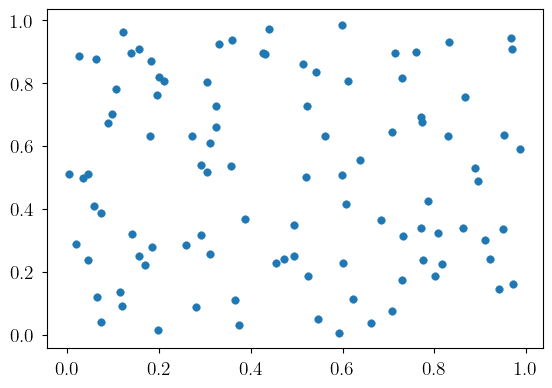

In [3]:
a = 0
b = 1
sample = (b-a) * np.random.random_sample((2,100)) + a
plt.scatter(x=sample[0], y=sample[1])
plt.show()

The Pareto frontier of the collected sample can be easiliy retrieved with `paretoset()` and is marked in orange below.

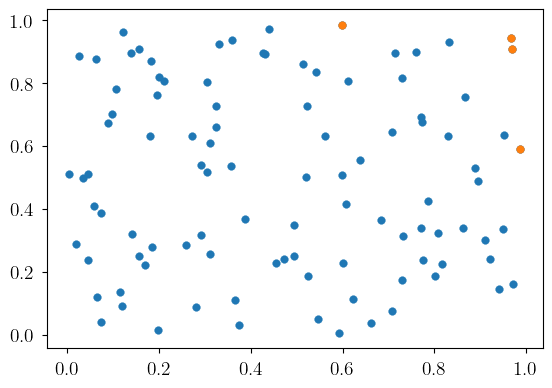

In [4]:
filter = paretoset(sample.T, sense=["max", "max"])

plt.scatter(x=sample[0], y=sample[1])
plt.scatter(x=sample[0][filter], y=sample[1][filter])
plt.show()

### 2. Pareto analysis of (2,1)-tree of collected solution set

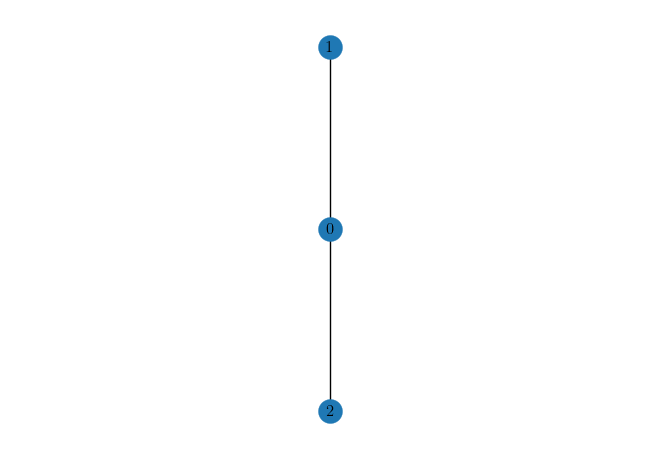

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

T = nx.balanced_tree(2, 1)

pos = graphviz_layout(T, prog="twopi")
nx.draw(T, pos, with_labels=True)
plt.show()

Load solution from `surdata` or run `sur.py --topo 2,1 --time 0.5` (30 min runtime). `config.py` is set with the following parameters

* 'protocol': 'ndsrs',
* 'p_gen': 0.9,
* 'p_swap': 1,
* 'return_data': 'avg',
* 'progress_bar': None,
* 'total_time': 1000,
* 'N_samples': 1000,
* 'p_cons': 0.225,
* 'qbits_per_channel': 5,
* 'cutoff': 28,
* 'M': 2,
* 'A': array([[0, 1, 1],
        [1, 0, 0],
        [1, 0, 0]])

In [6]:
with open('../../surdata/SU_tree2,1_0.50h_objective-meanopt_SEED42_03-28-2024_16:51:58.pkl', 'rb') as file: 
    # Load the object from the file
    sur_loaded_data = pickle.load(file)
model = sur_loaded_data

In [7]:
model.vals

{'protocol': 'ndsrs',
 'p_gen': 0.9,
 'p_swap': 1,
 'return_data': 'avg',
 'progress_bar': None,
 'total_time': 1000,
 'N_samples': 1000,
 'p_cons': 0.225,
 'qbits_per_channel': 5,
 'cutoff': 28,
 'M': 2,
 'A': array([[0, 1, 1],
        [1, 0, 0],
        [1, 0, 0]])}

In [14]:
# How to calculate which cutoff time to set (given total runtime T, M, Fnew and Fapp)
T = 1000
M = 4
Fnew = 0.888
Fapp = 0.6
-T*np.log( 3/(4*Fnew-1) * ((4*Fapp-1)/3)**(1/M) )

28.800089826157972

In [15]:
virtual_neighbours = pd.DataFrame(model.y) # N = 1000
virtual_neighbours.columns = [f'node {i}' for i in range(3)]
virtual_neighbours = virtual_neighbours[['node 0', 'node 1', 'node 2']]
virtual_neighbours

,node 0,node 1,node 2
0,0.243243,1.123123,1.120120
1,0.978979,1.464464,1.470470
2,0.162162,1.085085,1.077077
3,0.380380,1.188188,1.190190
4,1.993994,1.302302,1.302302
...,...,...,...
225,1.872873,1.636637,1.645646
226,1.858859,1.603604,1.594595
227,1.872873,1.636637,1.645646
228,1.872873,1.636637,1.645646


In [16]:
vn = virtual_neighbours.to_numpy()
filter = paretoset(vn, sense=["max"]*3)

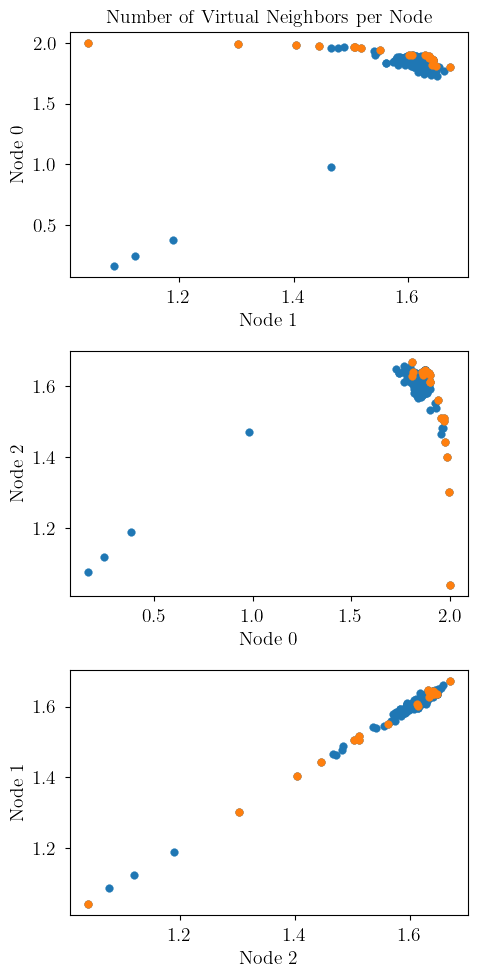

In [17]:
fig, axs = plt.subplots(3,sharey=False, sharex=False, figsize=[5,10])
labels = [1,0,2,1]
for i,ax in enumerate(axs):
    ax.scatter(x=vn[:,labels[i]], y=vn[:,labels[i+1]])
    ax.scatter(x=vn[:,labels[i]][filter], y=vn[:,labels[i+1]][filter])
    ax.set_xlabel(f'Node {labels[i]}')
    ax.set_ylabel(f'Node {labels[i+1]}')
axs[0].set_title('Number of Virtual Neighbors per Node')
plt.tight_layout()
plt.show()

In [18]:
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
virtual_neighbours['filter'] = filter
fig = px.scatter_3d(virtual_neighbours, x=virtual_neighbours.columns[0], y=virtual_neighbours.columns[1], z=virtual_neighbours.columns[2],
              color='filter')
plt.tight_layout()
fig.show()

<Figure size 640x440 with 0 Axes>

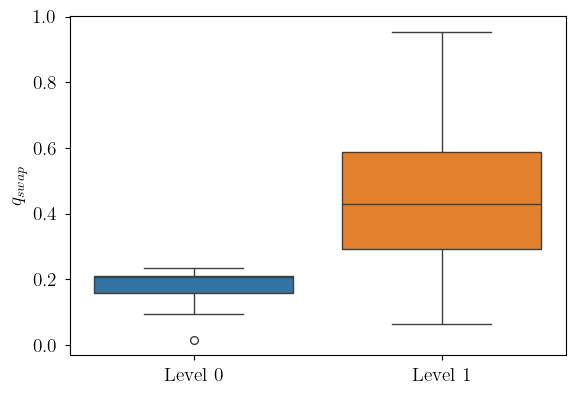

In [19]:
fig, ax = plt.subplots()
g = sns.boxplot(model.X_df[filter].drop(['Iteration'], axis=1))
g.set_xticklabels(['Level 0', 'Level 1'])
plt.ylabel(r'$q_{swap}$')
plt.show()

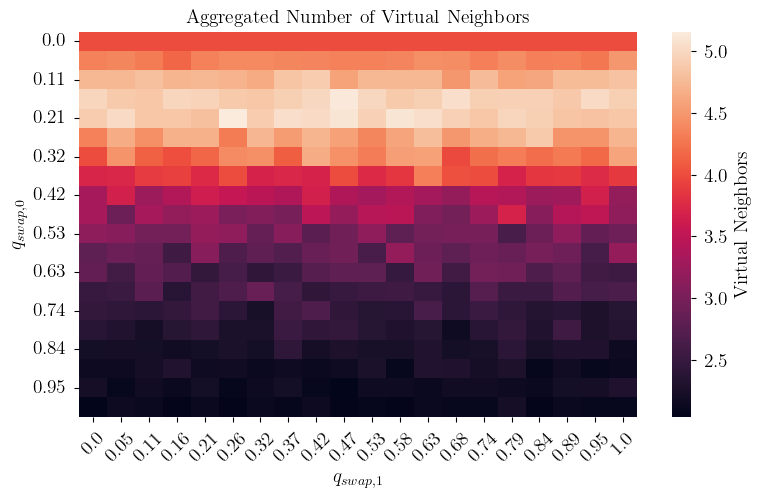

In [20]:
df_plot = pd.read_pickle('../usecase_cd/21tree-heatmap.pkl')
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(df_plot, cbar_kws={'label': 'Virtual Neighbors'})
plt.xlabel(r'$q_{swap,1}$')
plt.ylabel(r'$q_{swap,0}$')
plt.yticks(rotation=0) 
plt.xticks(rotation=45) 
plt.title('Aggregated Number of Virtual Neighbors')
plt.show()

<div style="max-width:400px;margin-left: auto; margin-right: 0